# **Analyzing "Census Adult Income" Dataset**

# Step 1: Import Libraries and Explore the Dataset

## **Objectives**
- Load the dataset and examine its structure.
- Check the first few rows of the data.
- Assess the column data types and summary statistics.
- Identify any missing values.

## **Code**


In [25]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/tokamohamed/Documents/final-project-444323-70e7c50e4cc5.json"


In [105]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize BigQuery client (if working with BigQuery)
from google.cloud import bigquery
from google.cloud import bigquery

client = bigquery.Client()


In [2]:
!pip install google-cloud-bigquery


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [7]:
!pip install --upgrade google-cloud-bigquery


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [106]:
# Corrected query with valid column names
query = """
  SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2020-01-01' AND '2024-11-29'
ORDER BY RAND()
LIMIT 30000;

"""
query_job = client.query(query)
# Convert query results into a dictionary
results = query_job.result()  # This fetches all the rows from the query



In [107]:
# Load it directly into a pandas DataFrame
df = pd.DataFrame([dict(row) for row in results])


In [108]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-67802000020,2024-02-29,2651,HY-VEE / WAVERLY,1311 4 STREET SW,WAVERLY,50677.0,POINT(-92.473949023 42.712225012),None,BREMER,...,17210,CENTURY FARMS SINGLE BARREL STRAIGHT BOURBON W...,6,750,24.00,36.00,1,36.00,0.75,0.19
1,INV-29171900019,2020-08-03,2720,HY-VEE GAS #3 / WDM,7280 UNIVERSITY AVE,WEST DES MOINES,50266.0,POINT(-93.807443 41.600395),25,DALLAS,...,25601,SEAGRAMS 7 CROWN MINI,12,50,6.17,9.26,3,27.78,0.15,0.03
2,INV-24608500025,2020-01-16,2652,HY-VEE DRUGSTORE / MASON CITY,875 4TH ST SW,MASON CITY,50401.0,POINT(-93.213856 43.148257),17,CERRO GORDO,...,36304,HAWKEYE VODKA,24,375,1.86,2.79,24,66.96,9.00,2.37
3,INV-62488000047,2023-09-20,2512,HY-VEE WINE AND SPIRITS #1 (1281) / IOWA CITY,1720 WATERFRONT DR,IOWA CITY,52240.0,POINT(-91.529426133 41.642516428),None,JOHNSON,...,66936,GRANGALA TRIPLE ORANGE LIQUEUR,12,750,11.02,16.53,12,198.36,9.00,2.37
4,INV-39759200013,2021-09-02,4674,KUM & GO #227 / AMES,2108 ISAAC NEWTON DR,AMES,50010.0,POINT(-93.585891 42.009586),85,STORY,...,28275,JIM BEAM PEACH MINI,12,50,7.00,10.50,3,24.30,0.15,0.03


In [ ]:
# [
#   {
#     "name": "invoice_and_item_number",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Concatenated invoice and line number associated with the liquor order. This provides a unique identifier for the individual liquor products included in the store order.",
#     "fields": []
#   },
#   {
#     "name": "date",
#     "mode": "NULLABLE",
#     "type": "DATE",
#     "description": "Date of order",
#     "fields": []
#   },
#   {
#     "name": "store_number",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Unique number assigned to the store who ordered the liquor.",
#     "fields": []
#   },
#   {
#     "name": "store_name",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Name of store who ordered the liquor.",
#     "fields": []
#   },
#   {
#     "name": "address",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Address of store who ordered the liquor.",
#     "fields": []
#   },
#   {
#     "name": "city",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "City where the store who ordered the liquor is located",
#     "fields": []
#   },
#   {
#     "name": "zip_code",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Zip code where the store who ordered the liquor is located",
#     "fields": []
#   },
#   {
#     "name": "store_location",
#     "mode": "NULLABLE",
#     "type": "GEOGRAPHY",
#     "description": "Location of store who ordered the liquor. The Address, City, State and Zip Code are geocoded to provide geographic coordinates. Accuracy of geocoding is dependent on how well the address is interpreted and the completeness of the reference data used.",
#     "fields": []
#   },
#   {
#     "name": "county_number",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Iowa county number for the county where store who ordered the liquor is located",
#     "fields": []
#   },
#   {
#     "name": "county",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "County where the store who ordered the liquor is located",
#     "fields": []
#   },
#   {
#     "name": "category",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Category code associated with the liquor ordered",
#     "fields": []
#   },
#   {
#     "name": "category_name",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Category of the liquor ordered.",
#     "fields": []
#   },
#   {
#     "name": "vendor_number",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "The vendor number of the company for the brand of liquor ordered",
#     "fields": []
#   },
#   {
#     "name": "vendor_name",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "The vendor name of the company for the brand of liquor ordered",
#     "fields": []
#   },
#   {
#     "name": "item_number",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Item number for the individual liquor product ordered.",
#     "fields": []
#   },
#   {
#     "name": "item_description",
#     "mode": "NULLABLE",
#     "type": "STRING",
#     "description": "Description of the individual liquor product ordered.",
#     "fields": []
#   },
#   {
#     "name": "pack",
#     "mode": "NULLABLE",
#     "type": "INTEGER",
#     "description": "The number of bottles in a case for the liquor ordered",
#     "fields": []
#   },
#   {
#     "name": "bottle_volume_ml",
#     "mode": "NULLABLE",
#     "type": "INTEGER",
#     "description": "Volume of each liquor bottle ordered in milliliters.",
#     "fields": []
#   },
#   {
#     "name": "state_bottle_cost",
#     "mode": "NULLABLE",
#     "type": "FLOAT",
#     "description": "The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered",
#     "fields": []
#   },
#   {
#     "name": "state_bottle_retail",
#     "mode": "NULLABLE",
#     "type": "FLOAT",
#     "description": "The amount the store paid for each bottle of liquor ordered",
#     "fields": []
#   },
#   {
#     "name": "bottles_sold",
#     "mode": "NULLABLE",
#     "type": "INTEGER",
#     "description": "The number of bottles of liquor ordered by the store",
#     "fields": []
#   },
#   {
#     "name": "sale_dollars",
#     "mode": "NULLABLE",
#     "type": "FLOAT",
#     "description": "Total cost of liquor order (number of bottles multiplied by the state bottle retail)",
#     "fields": []
#   },
#   {
#     "name": "volume_sold_liters",
#     "mode": "NULLABLE",
#     "type": "FLOAT",
#     "description": "Total volume of liquor ordered in liters. (i.e. (Bottle Volume (ml) x Bottles Sold)/1,000)\"",
#     "fields": []
#   },
#   {
#     "name": "volume_sold_gallons",
#     "mode": "NULLABLE",
#     "type": "FLOAT",
#     "description": "Total volume of liquor ordered in gallons. (i.e. (Bottle Volume (ml) x Bottles Sold)/3785.411784)\"",
#     "fields": []
#   }
# ]

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   invoice_and_item_number  30000 non-null  object 
 1   date                     30000 non-null  object 
 2   store_number             30000 non-null  object 
 3   store_name               30000 non-null  object 
 4   address                  29991 non-null  object 
 5   city                     29991 non-null  object 
 6   zip_code                 29991 non-null  object 
 7   store_location           28147 non-null  object 
 8   county_number            15277 non-null  object 
 9   county                   29991 non-null  object 
 10  category                 29998 non-null  object 
 11  category_name            29998 non-null  object 
 12  vendor_number            30000 non-null  object 
 13  vendor_name              30000 non-null  object 
 14  item_number           

In [110]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,11.883100,812.569333,12.190775,18.286232,11.664067,161.150495,8.981292,2.366952
std,8.077529,529.722988,13.495788,20.240753,26.806213,442.780114,31.211764,8.245526
min,1.000000,20.000000,0.890000,1.340000,-48.000000,-859.320000,-27.000000,-7.130000
25%,6.000000,375.000000,6.000000,9.000000,3.000000,44.970000,1.500000,0.390000
50%,12.000000,750.000000,9.060000,13.590000,6.000000,89.960000,4.500000,1.180000
75%,12.000000,1000.000000,14.990000,22.490000,12.000000,166.560000,10.500000,2.770000
max,60.000000,5250.000000,1247.200000,1870.800000,1200.000000,18816.000000,2100.000000,554.760000


In [111]:
df.nunique()


invoice_and_item_number    30000
date                        1356
store_number                2241
store_name                  2291
address                     2288
city                         445
zip_code                     843
store_location              6090
county_number                 99
county                        99
category                      97
category_name                 44
vendor_number                241
vendor_name                  178
item_number                 3117
item_description            2588
pack                          16
bottle_volume_ml              20
state_bottle_cost           1055
state_bottle_retail         1056
bottles_sold                  90
sale_dollars                3563
volume_sold_liters           181
volume_sold_gallons          178
dtype: int64

# Step 2: Data Cleaning

1. Check the missing values

In [112]:
df.isnull().sum()


invoice_and_item_number        0
date                           0
store_number                   0
store_name                     0
address                        9
city                           9
zip_code                       9
store_location              1853
county_number              14723
county                         9
category                       2
category_name                  2
vendor_number                  0
vendor_name                    0
item_number                    0
item_description               0
pack                           0
bottle_volume_ml               0
state_bottle_cost              0
state_bottle_retail            0
bottles_sold                   0
sale_dollars                   0
volume_sold_liters             0
volume_sold_gallons            0
dtype: int64

In [113]:
df.drop(['county_number','store_location'], axis=1,inplace=True)

In [114]:
df.dropna(inplace=True)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29989 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   invoice_and_item_number  29989 non-null  object 
 1   date                     29989 non-null  object 
 2   store_number             29989 non-null  object 
 3   store_name               29989 non-null  object 
 4   address                  29989 non-null  object 
 5   city                     29989 non-null  object 
 6   zip_code                 29989 non-null  object 
 7   county                   29989 non-null  object 
 8   category                 29989 non-null  object 
 9   category_name            29989 non-null  object 
 10  vendor_number            29989 non-null  object 
 11  vendor_name              29989 non-null  object 
 12  item_number              29989 non-null  object 
 13  item_description         29989 non-null  object 
 14  pack                     29

2. Check the duplicates

In [116]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


##### 3. Feature extraction

In [117]:
df['date']= pd.to_datetime(df['date'])
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month

4. remove unnececarry columns 

In [118]:
df.drop(['date','invoice_and_item_number','address','city','zip_code','category','vendor_number','item_number','item_description','volume_sold_gallons'], axis=1 , inplace=True)

3. Handling the Data Types

In [120]:
df['store_number'] = pd.to_numeric(df['store_number'], errors='coerce')


In [122]:
df.dtypes

store_number             int64
store_name              object
county                  object
category_name           object
vendor_name             object
pack                     int64
bottle_volume_ml         int64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold             int64
sale_dollars           float64
volume_sold_liters     float64
year                     int32
month                    int32
dtype: object

4. Addressing Outliers or Anomalies

array([[<Axes: title={'center': 'store_number'}>,
        <Axes: title={'center': 'pack'}>,
        <Axes: title={'center': 'bottle_volume_ml'}>],
       [<Axes: title={'center': 'state_bottle_cost'}>,
        <Axes: title={'center': 'state_bottle_retail'}>,
        <Axes: title={'center': 'bottles_sold'}>],
       [<Axes: title={'center': 'sale_dollars'}>,
        <Axes: title={'center': 'volume_sold_liters'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>, <Axes: >, <Axes: >]],
      dtype=object)

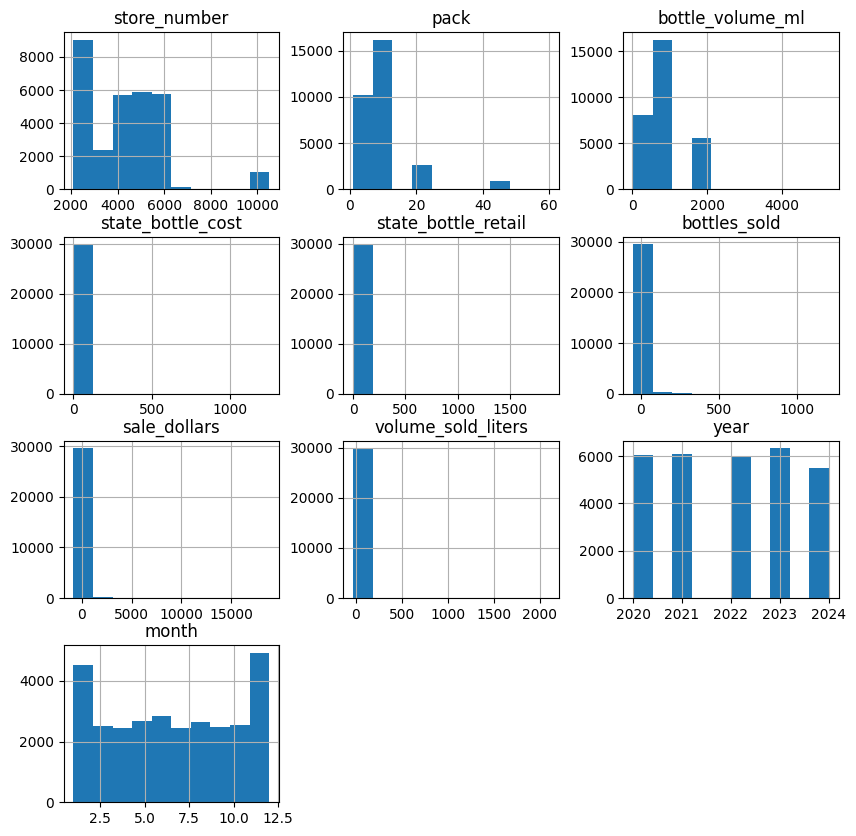

In [123]:
df.hist(figsize=(10,10))

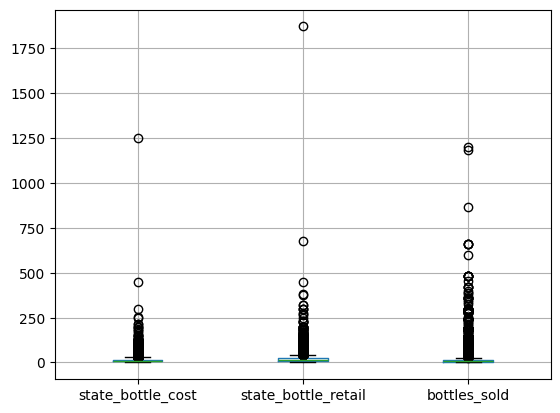

In [131]:
import matplotlib.pyplot as plt
df[['state_bottle_cost', 'state_bottle_retail', 'bottles_sold']].boxplot()
plt.show()

5. Cleaning Up Invalid or Inconsistent Entries

In [124]:
df.describe()

,store_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month
count,29989.000000,29989.000000,29989.000000,29989.000000,29989.000000,29989.000000,29989.000000,29989.000000,29989.000000,29989.000000
mean,4389.942012,11.884458,812.600620,12.187885,18.281897,11.667078,161.173488,8.983881,2021.970956,6.555637
std,1687.714323,8.078510,529.707873,13.494239,20.238428,26.810607,442.857097,31.217184,1.397941,3.381221
min,2106.000000,1.000000,20.000000,0.890000,1.340000,-48.000000,-859.320000,-27.000000,2020.000000,1.000000
25%,2648.000000,6.000000,375.000000,6.000000,9.000000,3.000000,44.970000,1.500000,2021.000000,4.000000
50%,4291.000000,12.000000,750.000000,9.060000,13.590000,6.000000,89.960000,4.500000,2022.000000,7.000000
75%,5423.000000,12.000000,1000.000000,14.990000,22.490000,12.000000,166.560000,10.500000,2023.000000,9.000000
max,10506.000000,60.000000,5250.000000,1247.200000,1870.800000,1200.000000,18816.000000,2100.000000,2024.000000,12.000000


In [128]:
df = df[(df[['bottles_sold', 'sale_dollars', 'volume_sold_liters']] >= 0).all(axis=1)]

In [147]:
numeric_columns = df.select_dtypes(include=['number'])


In [148]:
numeric_columns.shape

(29974, 10)

# Step 3: Data Visualization
- Create some charts, colleration matrix, heatmap, and any other additional thing you find by your search 
- Write conclusion under each of the chart

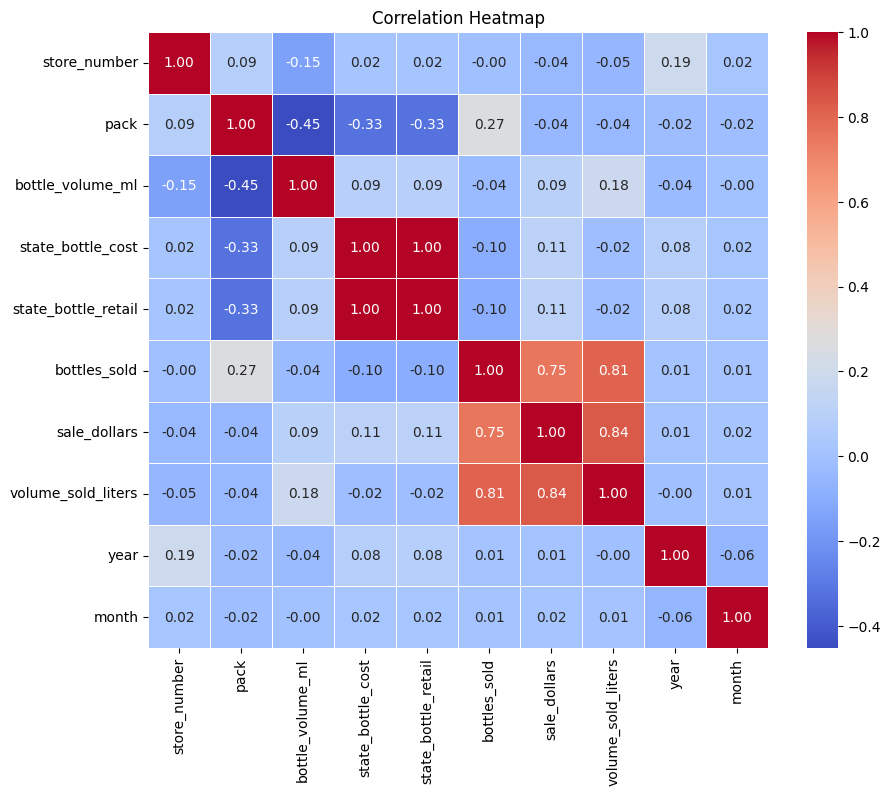

In [ ]:
plt.figure(figsize=(10, 8))  
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Step 4: Data Preprocessing
"Search for steps suitable for the following ML algorithms" 
- Encoding categorical data.
- Scaling or normalizing numerical features.
- Feature engineering (e.g., creating or combining features).


In [155]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
nums = df.select_dtypes(include=['int64', 'float64']).columns

df[nums]= scaler.fit_transform(df[nums])


In [156]:
df

,store_number,store_name,county,category_name,vendor_name,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month,category_name_freq_encoded,county_freq_encoded,vendor_name_freq_encoded
0,0.064881,HY-VEE / WAVERLY,BREMER,STRAIGHT BOURBON WHISKIES,"AMERICAN HERITAGE DISTILLERS, LLC / CENTURY FA...",0.084746,0.139579,0.018543,0.018540,0.000000,0.001842,0.000348,2024,2,0.492625,0.034422,0.001105
1,0.073095,HY-VEE GAS #3 / WDM,DALLAS,BLENDED WHISKIES,DIAGEO AMERICAS,0.186441,0.005736,0.004237,0.004237,0.001668,0.001405,0.000062,2020,8,0.256182,0.089392,1.000000
2,0.065000,HY-VEE DRUGSTORE / MASON CITY,CERRO GORDO,AMERICAN VODKAS,LUXCO INC,0.389831,0.067878,0.000778,0.000776,0.019183,0.003487,0.004276,2020,1,1.000000,0.099579,0.436810
3,0.048333,HY-VEE WINE AND SPIRITS #1 (1281) / IOWA CITY,JOHNSON,IMPORTED CORDIALS & LIQUEURS,SAZERAC COMPANY INC,0.186441,0.139579,0.008128,0.008125,0.009174,0.010471,0.004276,2023,9,0.147289,0.235511,0.971056
4,0.305714,KUM & GO #227 / AMES,STORY,STRAIGHT BOURBON WHISKIES,JIM BEAM BRANDS,0.186441,0.005736,0.004902,0.004900,0.001668,0.001220,0.000062,2021,9,0.492625,0.148753,0.542422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.980119,CASEY'S #4294 / CORYDON,WAYNE,SPICED RUM,DIAGEO AMERICAS,0.186441,0.139579,0.006900,0.006900,0.001668,0.002199,0.001062,2024,6,0.269848,0.004566,1.000000
29996,0.329405,CASEY'S GENERAL STORE #2559 / GRANGER,DALLAS,STRAIGHT BOURBON WHISKIES,JIM BEAM BRANDS,0.186441,0.139579,0.008112,0.008109,0.002502,0.003436,0.001419,2023,5,0.492625,0.089392,0.542422
29997,0.949643,KWIK STAR #1189 / DE SOTO,DALLAS,AMERICAN VODKAS,FIFTH GENERATION INC,0.186441,0.067878,0.003635,0.003632,0.009174,0.005114,0.002133,2023,5,1.000000,0.089392,0.193327
29998,0.423095,NORTH SIDE LIQUOR & TOBACCO / DUBUQUE,DUBUQUE,IMPORTED VODKAS,PERNOD RICARD USA,0.152542,0.005736,0.005641,0.005638,0.007506,0.006242,0.000229,2023,10,0.166161,0.133649,0.342245


In [157]:
# Frequency Encoding
for col in ['category_name', 'county', 'vendor_name']:
    freq_encoding = df[col].value_counts()
    df[col + '_freq_encoded'] = df[col].map(freq_encoding)


In [ ]:
df.drop(['county','store_name','category_name','vendor_name'],axis=1,inplace=True)

In [164]:
df

,store_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month,category_name_freq_encoded,county_freq_encoded,vendor_name_freq_encoded
0,0.064881,0.084746,0.139579,0.018543,0.018540,0.000000,0.001842,0.000348,2024,2,2275,208,6
1,0.073095,0.186441,0.005736,0.004237,0.004237,0.001668,0.001405,0.000062,2020,8,1185,521,4527
2,0.065000,0.389831,0.067878,0.000778,0.000776,0.019183,0.003487,0.004276,2020,1,4614,579,1978
3,0.048333,0.186441,0.139579,0.008128,0.008125,0.009174,0.010471,0.004276,2023,9,683,1353,4396
4,0.305714,0.186441,0.005736,0.004902,0.004900,0.001668,0.001220,0.000062,2021,9,2275,859,2456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.980119,0.186441,0.139579,0.006900,0.006900,0.001668,0.002199,0.001062,2024,6,1248,38,4527
29996,0.329405,0.186441,0.139579,0.008112,0.008109,0.002502,0.003436,0.001419,2023,5,2275,521,2456
29997,0.949643,0.186441,0.067878,0.003635,0.003632,0.009174,0.005114,0.002133,2023,5,4614,521,876
29998,0.423095,0.152542,0.005736,0.005641,0.005638,0.007506,0.006242,0.000229,2023,10,770,773,1550


In [167]:
x = df[[
    'store_number', 'pack', 'bottle_volume_ml', 'state_bottle_cost',
    'state_bottle_retail', 'bottles_sold', 'volume_sold_liters',
    'year', 'month', 'category_name_freq_encoded',
    'county_freq_encoded', 'vendor_name_freq_encoded'
]]
y = df['sale_dollars']

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
x_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Step 5: Machine Learning Algorithms
### ~ Dataset Characteristics
- **Goal:** Predict income_bracket (binary classification: <=50K or >50K).
- **Features:**
Mix of numerical (e.g., age, hours_per_week) and categorical (e.g., workclass, occupation) data.
Some features (e.g., capital_gain and capital_loss) have skewed distributions or high sparsity.
- **The target is imbalanced:** typically, fewer people earn >50K.

## 1. multiple Linear Regression
**Why??**
- Works well for binary classification.
- Performs efficiently on structured datasets with preprocessed data.
- Handles imbalanced classes reasonably well when combined with class weights or balancing techniques.

In [169]:
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [170]:
y_pred = model.predict(X_test)


In [171]:
mse = mean_squared_error(y_test, y_pred)
mse

0.00016715465053038906

In [172]:
rmse=np.sqrt(mse)
rmse

0.012928830207346257

In [173]:
r2 = r2_score(y_test, y_pred)
r2

0.7255894567627424

In [174]:
coefficients = pd.DataFrame({
    'Feature': x.columns,
    'Coefficient': model.coef_
})
coefficients

,Feature,Coefficient
0,store_number,-1.163557e-03
1,pack,-1.382387e-02
2,bottle_volume_ml,-1.207072e-02
3,state_bottle_cost,-1.079052e-01
4,state_bottle_retail,3.546513e-01
5,bottles_sold,3.171812e-01
6,volume_sold_liters,9.698150e-01
7,year,3.030088e-05
8,month,1.856674e-05
9,category_name_freq_encoded,-5.609678e-07
